<a href="https://colab.research.google.com/github/ReynaldiJ/portfolio/blob/main/Text_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UAS Text Mining

---


Reynaldi Joely - 2540124356

---


Link Colab: https://colab.research.google.com/drive/1XQ1mPWkQZZzgNmxVifw9nrhInwayfFIB?usp=sharing

---

Link Video: https://youtu.be/lqgAOlzNcyk

In [ ]:
import zipfile
zip_file_path = '/content/Data.zip'
extract_folder = 'extracted_data'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# LLM (Multilabel Classification)

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
!pip install transformers[torch]
!pip install accelerate -U

## Data

Dataset yang digunakan ini diambil dari paket ujian ('/content/extracted_data/C/data_1C.csv')  di soal nomor 1 kita diminta untuk menggunakan LLM untuk melakukan klasifikasi multilabel terhadap data tweet yang dicantumkan.

In [ ]:
df = pd.read_csv('/content/extracted_data/C/data_1C.csv', encoding='latin-1')

In [ ]:
df.head()

,Unnamed: 0,index,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other
0,0,13012,Subhan?Allah Kenangan yg Tidak akan Terlupakan...,1,0,1,0,0,0,0,0,1
1,1,5594,"Direksi Pertamina Dirombak, ESDM Mau Premium t...",0,0,0,0,0,0,0,0,0
2,2,347,"3. Karena berbasis teknologi digital, Presiden...",0,0,0,0,0,0,0,0,0
3,3,4356,RT USER: USER USER USER kebanyakan alasan...\n...,1,1,1,0,0,0,0,1,0
4,4,10958,Ganyang PKI dg segala anteknya... URL,1,0,0,1,0,1,0,0,0


In [ ]:
df = df.drop(['Unnamed: 0','index'], axis=1)

In [ ]:
df.isnull().sum()

Tweet            0
HS               0
Abusive          0
HS_Individual    0
HS_Group         0
HS_Religion      0
HS_Race          0
HS_Physical      0
HS_Gender        0
HS_Other         0
dtype: int64

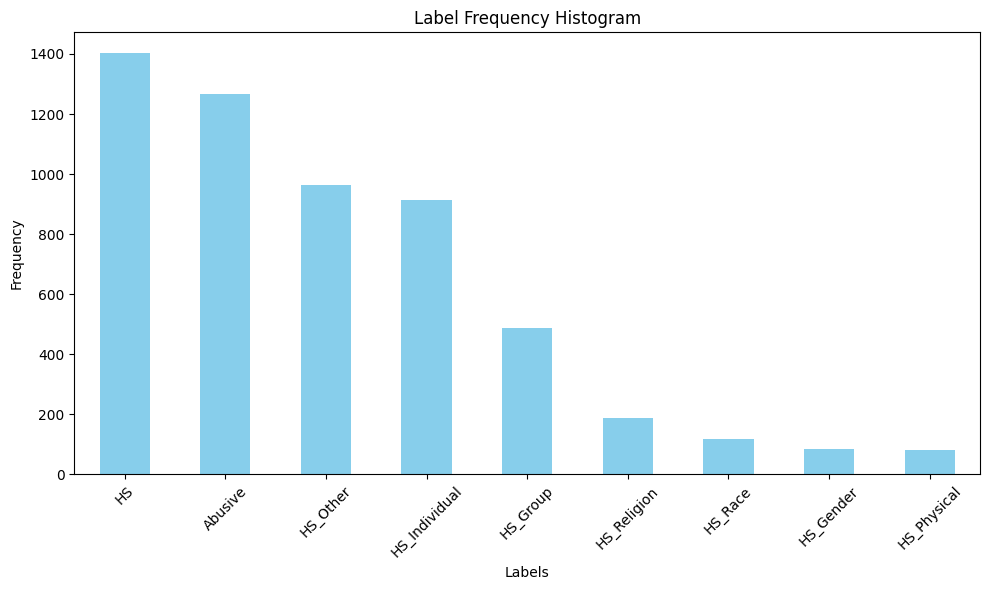

In [ ]:
label_counts = df.iloc[:, 3:].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Frequency Histogram')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

encodings = tokenizer(list(df['Tweet']), truncation=True, padding=True, max_length=128)
labels = df[['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other']].values

## Splitting Data

Kumpulan code dibawah digunakan untuk membagi data kedalam format yang akan digunakan [['train', 'test','split'], [80%, 10%, 10%]].

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(list(df['Tweet']), labels, test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(val_texts, val_labels, test_size=0.5, random_state=42)

## Pre-processing

Code dibawah digunakan untuk mengkonversi bentuk teks menjadi representasi yang dapat dimasukan kedalam model BERT, kemudian representasi data tersebut dibagi ke dalam format yang digunakan untuk train, test, split dalam pemodelan LLM for multilabel text classification.

Function dibawah dapat dibagi menjadi 3 task besar yaitu:

* __init__(self, encodings, labels): Inisialisasi dataset dengan encoding teks (encodings) dan label (labels).
* __getitem__(self, idx): Mengambil item pada indeks tertentu idx dalam dataset. Mengubah setiap encoding teks dan label menjadi tensor PyTorch.
* __len__(self): Mengembalikan panjang dataset.

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)
test_dataset = TextDataset(test_encodings, test_labels)

## Modelling


BertForSequenceClassification adalah sejenis BERT yang dirancang untuk tugas *sequence classification*. Model ini memiliki layerklasifikasi di atas model BERT yang dapat dioptimalkan untuk tugas-tugas seperti analisis sentimen, inferensi bahasa alami, atau tugas klasifikasi lainnya di mana inputnya merupakan *text sequence*.

Model ini sudah memiliki sebuah pretrained weight dari model bert-base-multilingual-cased, yang merupakan model multilingual dari BERT yang sudah dilatih menggunakan korpus teks dari berbagai bahasa.

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=9)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tuning

*fine-tuning* BERT untuk klasifikasi multilabel, harus dipastikan modelnya sudah dioptimasi untuk memiliki output logit dari masing" label/class, kita juga harus menggunakan loss function yang sesuai seperti sigmoid activation di TensorFlow, dan training dan evaluation juga harus disesuaikan untuk menangani output multilabel secara baik.

In [ ]:
learning_rates = [5e-5, 3e-5, 2e-5]
batch_sizes = [8, 16]

for lr in learning_rates:
    for batch_size in batch_sizes:
        training_args = TrainingArguments(
            output_dir=f'./results_lr{lr}_bs{batch_size}',
            num_train_epochs=3,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            warmup_steps=500,
            weight_decay=0.01,
            learning_rate=lr,
            logging_dir='./logs',
            logging_steps=10,
            evaluation_strategy="epoch"
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset
        )

        trainer.train()
        metrics = trainer.evaluate()
        print(f"Learning Rate: {lr}, Batch Size: {batch_size}")
        print(metrics)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.180200,0.351672
2,0.125800,0.363567
3,0.168600,0.338262


Learning Rate: 5e-05, Batch Size: 8
{'eval_loss': 0.3382619321346283, 'eval_runtime': 2.348, 'eval_samples_per_second': 140.121, 'eval_steps_per_second': 17.888, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.096800,0.338565
2,0.104300,0.330739
3,0.118000,0.336802


Learning Rate: 5e-05, Batch Size: 16
{'eval_loss': 0.336801677942276, 'eval_runtime': 2.3486, 'eval_samples_per_second': 140.085, 'eval_steps_per_second': 8.942, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.054000,0.380428
2,0.040300,0.394534
3,0.078600,0.410869


Learning Rate: 3e-05, Batch Size: 8
{'eval_loss': 0.4108690023422241, 'eval_runtime': 2.3544, 'eval_samples_per_second': 139.739, 'eval_steps_per_second': 17.839, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.020600,0.444356
2,0.036900,0.442483
3,0.028700,0.472583


Learning Rate: 3e-05, Batch Size: 16
{'eval_loss': 0.4725830554962158, 'eval_runtime': 2.3577, 'eval_samples_per_second': 139.541, 'eval_steps_per_second': 8.907, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.019600,0.459995
2,0.022400,0.493579
3,0.042700,0.496685


Learning Rate: 2e-05, Batch Size: 8
{'eval_loss': 0.4966850280761719, 'eval_runtime': 2.3427, 'eval_samples_per_second': 140.437, 'eval_steps_per_second': 17.928, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.007700,0.518750
2,0.021900,0.530429
3,0.012600,0.542086


Learning Rate: 2e-05, Batch Size: 16
{'eval_loss': 0.542086124420166, 'eval_runtime': 2.3556, 'eval_samples_per_second': 139.668, 'eval_steps_per_second': 8.915, 'epoch': 3.0}


This hyperparameter tuning is also tasked to minimize the evaluation loss, and as we can see Learning Rate: 5e-05, Batch Size: 16 has the lowest eval_loss at 0.336801677942276

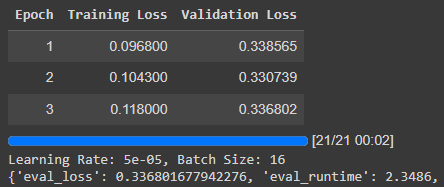

{'eval_loss': 0.336801677942276, 'eval_runtime': 2.3486, 'eval_samples_per_second': 140.085, 'eval_steps_per_second': 8.942, 'epoch': 3.0}

## Training Model

Selama training, pastikan model menghasilkan output logit dari setiap class. Model ini juga dapat dilatih menggunakan pendekatan multilabel, yang menggunakan 2 hyperparameter tuning {Learning Rate: 5e-05, Batch Size: 16}.

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=5e-05,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)
# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)
# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.007300,0.518770
2,0.034700,0.574339
3,0.058000,0.538843


TrainOutput(global_step=495, training_loss=0.025390589146903068, metrics={'train_runtime': 187.7284, 'train_samples_per_second': 42.077, 'train_steps_per_second': 2.637, 'total_flos': 519611212175616.0, 'train_loss': 0.025390589146903068, 'epoch': 3.0})

## Evaluation

Code ini sudah disusun untuk melakukan evaluasi terhadap sebuah multilabel classification.

In [ ]:
# Evaluate the model
metrics = trainer.evaluate()

# Make predictions on the test set
predictions = trainer.predict(test_dataset)

# Calculate metrics
preds = torch.sigmoid(torch.tensor(predictions.predictions)).cpu().numpy()
pred_labels = (preds > 0.5).astype(int)

accuracy = accuracy_score(test_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, pred_labels, average='macro')

print("Metrics:", metrics)
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)

Metrics: {'eval_loss': 0.5388426780700684, 'eval_runtime': 2.3082, 'eval_samples_per_second': 142.534, 'eval_steps_per_second': 9.098, 'epoch': 3.0}
Test Accuracy: 0.5757575757575758
Test Precision: 0.6571683288292991
Test Recall: 0.5656505025189236
Test F1 Score: 0.5867843600115124


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, pred_labels)

# Calculate precision, recall, f1-score, support for each class
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, pred_labels, average='macro')

# Print metrics
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)

# Generate and print classification report
class_names = [f"Class {i}" for i in range(test_labels.shape[1])]  # Replace with actual class names if available
report = classification_report(test_labels, pred_labels, target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other'])
print("Classification Report:")
print(report)

Test Accuracy: 0.5757575757575758
Test Precision: 0.6571683288292991
Test Recall: 0.5656505025189236
Test F1 Score: 0.5867843600115124
Classification Report:
               precision    recall  f1-score   support

           HS       0.87      0.65      0.74       144
      Abusive       0.76      0.83      0.80       125
HS_Individual       0.73      0.45      0.56        95
     HS_Group       0.46      0.43      0.44        49
  HS_Religion       0.36      0.62      0.45        16
      HS_Race       0.42      0.62      0.50         8
  HS_Physical       0.67      0.33      0.44         6
    HS_Gender       0.80      0.67      0.73         6
     HS_Other       0.85      0.48      0.62       110

    micro avg       0.73      0.60      0.66       559
    macro avg       0.66      0.57      0.59       559
 weighted avg       0.76      0.60      0.66       559
  samples avg       0.41      0.37      0.37       559



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Clustering & Topic Extraction

In [ ]:
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data

In [ ]:
df2 = pd.read_csv('/content/extracted_data/C/data_2C.csv', encoding='latin-1')

In [ ]:
df2.head()

,Unnamed: 0,index,URL,Date,Tweet,ID,Username,Replies,Reetweets,Likes,Quotes,conversationId,Language,Links,Media,Retweeted Tweet,Bookmarks
0,0,6881,https://twitter.com/koesmanagalang/status/1657...,2023-05-13 17:02:16+00:00,@myrnn_ @secgron @bankbsi_id sistem sama orang...,1657431076921544705,koesmanagalang,1,0,0,0,1657192354829451264,in,NaN,NaN,NaN,0
1,1,9209,https://twitter.com/muhammad_dlya/status/16572...,2023-05-13 07:14:32+00:00,@setyodiwantoro @ZakyFarid @RochmatPurwanto @b...,1657283168054181888,muhammad_dlya,1,0,0,0,1657217322447425538,eu,NaN,NaN,NaN,0
2,2,13665,https://twitter.com/NuriSeptiyani/status/16566...,2023-05-11 13:40:46+00:00,@Kebosananan @detikcom iya nasabah bank konven...,1656655591488761857,NuriSeptiyani,2,0,1,1,1656576231545131008,in,NaN,NaN,NaN,0
3,3,17281,https://twitter.com/MasYusuf_/status/165646539...,2023-05-11 01:04:59+00:00,@bankbsi_id Gimana sih Min ini kok gak bisa la...,1656465393014419456,MasYusuf_,1,0,1,0,1655807602104872960,in,NaN,NaN,NaN,0
4,4,12216,https://twitter.com/KepoomrR/status/1656901084...,2023-05-12 05:56:16+00:00,"@ssstef_ @bankbsi_id BCA Sy bisa nih kayaknya,...",1656901084693278720,KepoomrR,0,0,0,0,1656869834557378560,in,NaN,NaN,NaN,0


In [ ]:
df2 = df2.drop(['Unnamed: 0','index'], axis=1)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6100 entries, 0 to 6099
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   URL              6100 non-null   object 
 1   Date             6100 non-null   object 
 2   Tweet            6100 non-null   object 
 3   ID               6100 non-null   int64  
 4   Username         6100 non-null   object 
 5   Replies          6100 non-null   int64  
 6   Reetweets        6100 non-null   int64  
 7   Likes            6100 non-null   int64  
 8   Quotes           6100 non-null   int64  
 9   conversationId   6100 non-null   int64  
 10  Language         6100 non-null   object 
 11  Links            226 non-null    object 
 12  Media            545 non-null    object 
 13  Retweeted Tweet  0 non-null      float64
 14  Bookmarks        6100 non-null   int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 715.0+ KB


In [ ]:
df2.isnull().sum()

URL                   0
Date                  0
Tweet                 0
ID                    0
Username              0
Replies               0
Reetweets             0
Likes                 0
Quotes                0
conversationId        0
Language              0
Links              5874
Media              5555
Retweeted Tweet    6100
Bookmarks             0
dtype: int64

In [ ]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df2['cleaned_tweet'] = df2['Tweet'].apply(clean_text)

In [ ]:
df2['cleaned_tweet'][0]

'sistem orangnya ganti gak sistem gak teretas cari countermeasures sekelas bank udah wajib tim cyber security isinya white hat hacker gue tau sih indo white hat hacker kriminal dibilangnya'

In [ ]:
display(df2['cleaned_tweet'])

0       sistem orangnya ganti gak sistem gak teretas c...
1                                                gak gitu
2       iya nasabah bank konven sprti bribnimandiri le...
3       gimana sih min gak bsi mobile nya gangguan sam...
4                                     bca sy nih kayaknya
                              ...                        
6095                                  cek mbankingnya kak
6096    mobile banking dah kebuka tp ga ngapa ngapain ...
6097                         ga bank mending koperasi aja
6098                                         kagak anying
6099                     top up dana mobile gabisa ya min
Name: cleaned_tweet, Length: 6100, dtype: object

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df2['cleaned_tweet'])

In [ ]:
X=pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())
X.head()

,__,___,_a,aa,aaaaa,aaaaargh,aaamiiin,aaja,aamiin,aba,...,zerbi,zero,zhang,ziber,ziva,zolim,zone,zonk,zoom,zuriah
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## A. Clustering

Kmeans adalah sebuah algoritma clustering yang bertujuan untuk membagi data kedalam K cluster yang berbeda, setiap data point merupakan milik cluster dengan centroid terdekat.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1)
    s_scores = []

    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        labels = kmeans.labels_
        s_score = silhouette_score(data, labels)
        s_scores.append(s_score)

    return iters, s_scores

max_k = 10
iters, s_scores = find_optimal_clusters(X, max_k)

for k, score in zip(iters, s_scores):
    print(f"Number of clusters: {k}, Silhouette Score: {score}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Number of clusters: 2, Silhouette Score: 0.004990555688541183
Number of clusters: 3, Silhouette Score: 0.006671330232733918
Number of clusters: 4, Silhouette Score: 0.008613286698513696
Number of clusters: 5, Silhouette Score: 0.009460992217972463
Number of clusters: 6, Silhouette Score: 0.010877764287064771
Number of clusters: 7, Silhouette Score: 0.01261458785331689
Number of clusters: 8, Silhouette Score: 0.012732972268818891
Number of clusters: 9, Silhouette Score: 0.012474960526939877
Number of clusters: 10, Silhouette Score: 0.013463086234488924


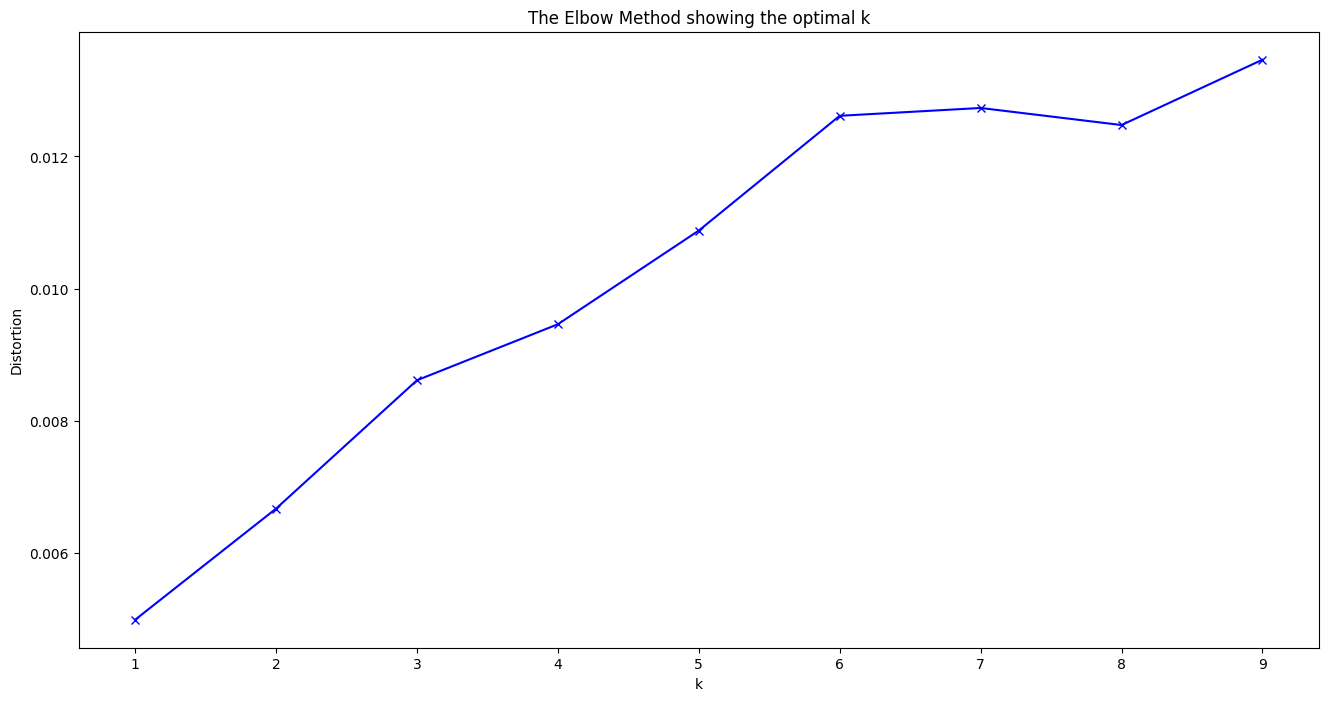

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(range(1,10), s_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Elbow Method adalah teknik untuk menentukan jumlah cluster yang optimal dalam algoritma clustering seperti KMeans. Salah satu cara untuk mengukur efektivitas clustering adalah menggunakan Silhouette Score. Silhouette Score mengukur seberapa mirip suatu data poin dengan cluster-nya sendiri dibandingkan dengan cluster lainnya, dengan nilai berkisar antara -1 dan 1.

In [ ]:
optimal_k = iters[s_scores.index(max(s_scores))]

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)
df2['Cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## B. Persona analysis for Clustering

In [ ]:
for cluster in range(optimal_k):
    print(f"Cluster {cluster}:")
    print(df2[df2['Cluster'] == cluster]['cleaned_tweet'].sample(5).values)

Cluster 0:
['smga teratasi' 'coba ambil uang atm (kartu atm bsi) om'
 'klik link email/site yg dikenal.'
 'mei : wib pelayanan bsi terburuk..... atm terblokir susah dilayani.... bawa buku tab.... emang pergi bawa buku tabungan....'
 'hallloo, bunga mayang, lampung utara jarak kc atm bsi terdekat??? gak daerah kc atm bsi']
Cluster 1:
['hai kak, terima kasih jago :)'
 'kak jg kayak gitu saldonya kabar" ya kak'
 '() coba hubungi kesini kak kalo emg diluar negeri'
 'sampe masuk dananya kak? kalo belum, coba hubungi call centernya aja'
 'alhamdulillah udah kak. kmrn lagsg laporan bank bsi diproses. jam dana dah lg rekening']
Cluster 2:
['dear gak transfer rekening bank rekening bsi via bsi mobile. sih?! lho.'
 'gimana sih transaksi atm gk bsi mobile apalagi??'
 'bsi mobile gangguan kah?'
 'tercatat detik bsi mobile down, x jam dahlahh pindah bank dulu.'
 'mobile ya?']
Cluster 3:
['bsi knp ya? aduh gaada duit, duitnya semuaa astagfirullah gabisa makan inii woi'
 'kalo tabungan haji aman gak 

| **Cluster** | **Pola** | **Persona** | **Deskripsi Persona** |
|-------------|----------|-------------|-----------------------|
| Cluster 0 | Keluhan terkait layanan ATM dan akses fisik ke ATM BSI | Frustrated ATM User | Mengalami kesulitan dengan akses fisik ke ATM dan pelayanan yang tidak memuaskan di cabang bank. Merasa tidak teratasi dengan baik oleh bank dan sering kali tidak membawa buku tabungan saat berpergian. |
| Cluster 1 | Respon positif dan dukungan dari nasabah yang telah menyelesaikan masalah atau menerima bantuan | Satisfied Customer | Telah menerima bantuan yang memadai dan merasa puas dengan penyelesaian masalah mereka. Sering memberikan feedback positif dan berterima kasih kepada layanan pelanggan. |
| Cluster 2 | Keluhan terkait gangguan atau masalah teknis pada aplikasi mobile banking BSI | Technical Trouble Seeker | Mengalami masalah teknis dengan aplikasi mobile banking BSI. Merasa frustrasi dengan gangguan yang berulang kali terjadi dan berdampak pada transaksi mereka. |
| Cluster 3 | Kekhawatiran tentang keamanan dana dan layanan yang tidak memadai | Security-Conscious Saver | Cemas tentang keamanan dana dan stabilitas layanan bank. Mengkhawatirkan tabungan haji dan merasa tidak ada solusi yang memadai dari pihak bank. |
| Cluster 4 | Keluhan tentang fungsi cek saldo yang bekerja, tetapi transaksi lainnya tidak | Balance Checker | Mengeluhkan keterbatasan fungsi aplikasi mobile banking yang hanya bisa cek saldo. Frustrasi karena tidak bisa melakukan transaksi penting lainnya melalui aplikasi. |
| Cluster 5 | Saran dan informasi tentang pemulihan layanan mobile banking BSI | Info Seeker | Aktif mencari informasi tentang status pemulihan layanan mobile banking BSI. Sering memberikan saran dan informasi kepada nasabah lain yang mengalami masalah serupa. |
| Cluster 6 | Pertanyaan tentang status transaksi dan lokasi ATM | Transaction Inquirer | Membutuhkan informasi spesifik tentang status transaksi dan lokasi ATM terdekat. Mengalami kebingungan dan mencari bantuan terkait masalah transaksi mereka. |
| Cluster 7 | Keluhan tentang layanan nasabah yang dianggap tidak memadai dan kehilangan dana | Discontent Customer | Kecewa dengan layanan nasabah yang dianggap tidak memadai dan kehilangan dana. Merasa tidak ada kompensasi yang memadai dari bank dan mempertimbangkan untuk berpindah ke bank lain. |
| Cluster 8 | Keluhan terkait top-up e-wallet dan verifikasi gagal | Top-Up Troubler | Mengalami kesulitan dalam melakukan top-up e-wallet dan frustrasi dengan proses verifikasi yang gagal. Sering mencoba solusi yang berbeda namun tetap mengalami masalah yang sama. |
| Cluster 9 | Kekhawatiran tentang keamanan dan reputasi bank, serta rencana untuk berpindah bank | Security Doubter | Meragukan kemampuan bank dalam menangani masalah keamanan dan mempertimbangkan untuk berpindah ke bank lain. Merasa sulit untuk mengembalikan kepercayaan terhadap bank setelah mengalami masalah keamanan. |

## C. Topic Extraction

LDA adalah teknik untuk unsupervised topic modelling yang mengekstraksi tema atau topik yang mendasar dari data teks dengan memanfaatkan inferensi statistik untuk memperkirakan struktur laten dalam dokumen-dokumen tersebut.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=optimal_k, random_state=42)
lda.fit(X)

tf_feature_names = vectorizer.get_feature_names_out()
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, tf_feature_names, 10)

Topic 0:
bsi bank bohong mas nya bgt kronologi aceh kasian sakit
Topic 1:
bsi min mobile ya udah saldo transfer cek ga kak
Topic 2:
sampe bsi gimana bank mbanking min ga aktivasi udah ya
Topic 3:
dm cek bank min bsi syariah tolong penipu ya terima
Topic 4:
bsi parah bank mbanking om uang ya lu emang mbak
Topic 5:
kak atm bsi aja bank gak aman ka data tunai
Topic 6:
bsi bank ya gabisa bener udah uang aja yg ga
Topic 7:
bsi bank alhamdulillah yg gak nasabah maintenance kacau kena transaksi
Topic 8:
bank bsi syariah april ga khairunnisa ipk ya server yg


## D. Persona analysis for Topic Extraction

In [ ]:
topic_assignments = lda.transform(X)
df2['Topic'] = topic_assignments.argmax(axis=1)

for topic in range(optimal_k):
    print(f"Topic {topic}:")
    print(df2[df2['Topic'] == topic]['cleaned_tweet'].sample(5).values)

Topic 0:
['heeh bun tp wingi iso wkkw'
 'iyaa aceh cuman bank berlaku lupa sekitaran segitu pokoknya bsi muncul timelinenya otonom daerahnya'
 'tp check doang' 'masuk mobile aj madih gabisa'
 'padaal daerah aceh cm bank aceh syariah bsimayoritas masy tanah rencong adlh nasabah bsi lhah kalo eror bginih lak yo kesian masy aceh jan sampe hestek jd trending pakdhe']
Topic 1:
['va bsi error kah' 'bsi mobile masi eror kah tf kemarin ga'
 'layanan cabang atm amp mobile banking bsi normal' 'ga cek saldo ga'
 'cek saldo bsi mobile atm bbrp ka coba cek berkala yes ku pagi coba bsi mobile perlahan fitur bisabisa ka']
Topic 2:
['mbanking kabar min terhambat urusan nasabah'
 'pol kak dryan gabisa ngapain sampe ku pindahin uangnya tp gabisa'
 'punten bade iraha mbanking normalna' 'muehehe gw tau'
 'bank bsi udah dibuka guys']
Topic 3:
['maap mulu lebaran udah maafin min ga pakai bsi hehe'
 'duluu pernahh kepepet danaaterpaksa jual pasar sekunder sukukk hr klo ga salah ingatyg nya ituh nyari pasar s

| **Topic** | **Pola** | **Persona** | **Deskripsi Persona** |
|-----------|----------|-------------|-----------------------|
| Topic 0 | Keluhan terkait dengan kondisi dan pelayanan bank BSI di Aceh | Aceh Service Critic | Merasa kecewa dengan layanan dan respons bank BSI di daerah Aceh, terutama terkait dengan pengelolaan dan kondisi layanan. |
| Topic 1 | Keluhan terkait dengan layanan mobile banking BSI | Mobile Banking User | Mengalami kesulitan dalam menggunakan layanan mobile banking BSI, seperti transfer dan pengecekan saldo, mencari solusi terkait masalah teknis. |
| Topic 2 | Keluhan terkait dengan gangguan atau masalah dalam penggunaan mbanking BSI | MBanking Activation Seeker | Kesulitan dalam mengaktifkan atau menggunakan mbanking BSI, mencari bantuan atau informasi untuk mengatasi masalah teknis. |
| Topic 3 | Keluhan atau pertanyaan terkait dengan keamanan dan penipuan di bank BSI | Security Concerned Customer | Khawatir tentang keamanan transaksi dan data pribadi di bank BSI, mencari klarifikasi atau perlindungan dari penipuan. |
| Topic 4 | Diskusi tentang kasus-kasus khusus seperti skimming di bank BSI | Special Case Investigator | Tertarik atau terlibat dalam masalah keamanan atau transaksi khusus di bank BSI, mencari informasi atau diskusi terkait kasus-kasus serius. |
| Topic 5 | Diskusi tentang masalah teknis atau keamanan di ATM BSI | ATM Security Observer | Peduli dengan keamanan uang dan transaksi di ATM BSI, mencari informasi tentang keamanan dan prosedur tunai. |
| Topic 6 | Keluhan terkait dengan pelayanan atau komunikasi dengan bank BSI | Customer Service Frustrator | Frustrasi dengan respons atau layanan pelanggan dari bank BSI, mencari solusi atau penjelasan atas keluhan mereka. |
| Topic 7 | Keluhan tentang gangguan atau masalah teknis dalam layanan bank BSI | Technical Service Affected User | Terpengaruh oleh gangguan atau masalah teknis dalam layanan atau perbaikan sistem dari bank BSI. |
| Topic 8 | Diskusi tentang masalah teknis atau layanan dari bank BSI | Technical Service Affected User | Terpengaruh oleh gangguan atau masalah teknis dalam layanan atau perbaikan sistem dari bank BSI. |

## Difference Between Clustering and Topic Extraction results

Perbedaan antara dua persona analysis menggunakan KMeans dan LDA:

| **Persona Analysis** | **Metode** | **Fokus Utama** | **Deskripsi Persona** | **Informasi Unik** |
|----------------------|------------|------------------|-----------------------|--------------------|
| LDA Persona          | LDA        | Topik utama yang diidentifikasi dari keluhan dan diskusi pengguna terkait bank BSI. | - Aceh Service Critic: Kekecewaan dengan layanan dan respons bank BSI di Aceh. <br> - Mobile Banking User: Kesulitan dalam menggunakan layanan mobile banking BSI. <br> - Security Concerned Customer: Khawatir tentang keamanan transaksi di bank BSI. | - Fokus pada kondisi pelayanan di daerah Aceh. <br> - Masalah teknis dalam aplikasi mobile banking. |
| KMeans Persona       | KMeans     | Pola kesamaan dalam data berdimensi tinggi. | - Frustrated ATM User: Keluhan terkait layanan ATM dan akses fisik. <br> - Satisfied Customer: Respon positif dari nasabah yang puas. <br> - Technical Trouble Seeker: Masalah teknis dalam aplikasi mobile banking. <br> - Security-Conscious Saver: Kekhawatiran tentang keamanan transaksi. | - Respons yang beragam terhadap layanan ATM dan komunikasi dengan bank. <br> - Kekecewaan terhadap layanan pelanggan dan kekhawatiran tentang keamanan transaksi. |

Kedua metode analisis ini memberikan pandangan yang komplementer dan mendalam tentang pengalaman pengguna terhadap layanan bank BSI. LDA fokus pada ekstraksi topik dari teks untuk mengungkapkan isu-isu spesifik yang dibicarakan pengguna, sementara KMeans memberikan wawasan tentang pola perilaku dan respons yang berbeda dari pelanggan dalam kelompok yang lebih luas, hal ini bisa terjadi karena LDA memanfaatkan inferential statistik yang terdapat dalam setiap dokumen dan distribusi kata, sementara KMeans melakukan clustering berdasarkan kemiripan pola. Kombinasi dari kedua analisis ini membantu dalam memahami tantangan yang dihadapi oleh pengguna, serta memberikan panduan untuk meningkatkan pengalaman pelanggan dan respons terhadap masalah yang muncul.

# Text Summarization

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
!pip install rouge
from rouge import Rouge

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data

In [ ]:
df3 = pd.read_csv('/content/extracted_data/C/data_3C.csv', encoding='latin-1')

In [ ]:
df3.head()

,Unnamed: 0,content,summary
0,9,"TEMPO.CO, Jakarta -Buffer zone atau kawasan pe...",Presiden Joko Widodo mengungkapkan bahwa renca...
1,10,"TEMPO.CO, Jakarta - Menteri BUMN Erick Thohir,...","Setelah kebakaran Depo Pertamina, Presiden Jok..."
2,11,"TEMPO.CO, Jakarta - Peneliti Pusat Studi Hukum...",Peneliti meminta Komisi Yudisial menggali moti...


In [ ]:
df3 = df3.drop('Unnamed: 0', axis=1)

In [ ]:
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'([.!,?;])', r' \1 ', text)
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text
df3['clean_content'] = df3['content'].apply(preprocess_text)

In [ ]:
df3['sentences'] = df3['clean_content'].apply(sent_tokenize)

In [ ]:
df3.head()

,content,summary,clean_content,sentences
0,"TEMPO.CO, Jakarta -Buffer zone atau kawasan pe...",Presiden Joko Widodo mengungkapkan bahwa renca...,"tempo . co , jakarta -buffer zone kawasan peny...","[tempo ., co , jakarta -buffer zone kawasan pe..."
1,"TEMPO.CO, Jakarta - Menteri BUMN Erick Thohir,...","Setelah kebakaran Depo Pertamina, Presiden Jok...","tempo . co , jakarta - menteri bumn erick thoh...","[tempo ., co , jakarta - menteri bumn erick th..."
2,"TEMPO.CO, Jakarta - Peneliti Pusat Studi Hukum...",Peneliti meminta Komisi Yudisial menggali moti...,"tempo . co , jakarta - peneliti pusat studi hu...","[tempo ., co , jakarta - peneliti pusat studi ..."


In [ ]:
df3['sentences'][0]

['tempo .',
 'co , jakarta -buffer zone kawasan penyangga memisahkan depo pertamina plumpang , jakarta utara , pemukiman warga menuai sorotan , diusulkan 2009 silam .',
 'presiden joko widodo jokowi gubernur dki jakarta 2012-2014 mengakui usulan dibahas era kepemimpinannya .',
 '"dulu direncanakan air kanan kirinya sungai , titik mencarikan solusi penduduknya situ , " jokowi ditemui mengunjungi pengungsi kebakaran depo pertamina rptra rasela , koja , jakarta utara , minggu , 5 maret 2023 .',
 '"tanah merah-nya padat penuh .',
 'dicarikan solusi .',
 'keamanan masyarakat , keselamatan masyarakat titik utama , " .',
 'tanah merah mengacu jalan tanah merah lokasi kebakaran .',
 'jokowi menyebut zona zona air , sungai memisahkan depo pemukiman .',
 'tujuannya melindungi objek vital depo .',
 '"karena barang-barang didalamnya barang-barang bahaya berdekatan masyarakat , pemukiman penduduk , " .',
 'heru ungkit buffer zonesebelumnya , kebakaran depo pertamina jumat malam , 20 .',
 '11 wib , 

## Feature Extraction and Sentence Scoring

Algoritma ini menggunakan TF-IDF untuk mengevaluasi pentingnya setiap kalimat dalam teks berdasarkan skor TF-IDF dari kata-kata dalam kalimat tersebut. Kalimat dengan skor tertinggi dianggap paling penting dan dapat digunakan untuk menyusun ringkasan dari teks aslinya.

In [ ]:
def score_sentences(sentences):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
    sentence_scores = tfidf_matrix.sum(axis=1).A1
    sentence_score_pairs = list(zip(sentences, sentence_scores))
    return sentence_score_pairs

df3['sentence_scores'] = df3['sentences'].apply(score_sentences)

In [ ]:
df3['sentence_scores'][0]

[('tempo .', 1.0),
 ('co , jakarta -buffer zone kawasan penyangga memisahkan depo pertamina plumpang , jakarta utara , pemukiman warga menuai sorotan , diusulkan 2009 silam .',
  4.135661276112638),
 ('presiden joko widodo jokowi gubernur dki jakarta 2012-2014 mengakui usulan dibahas era kepemimpinannya .',
  3.6859847448936947),
 ('"dulu direncanakan air kanan kirinya sungai , titik mencarikan solusi penduduknya situ , " jokowi ditemui mengunjungi pengungsi kebakaran depo pertamina rptra rasela , koja , jakarta utara , minggu , 5 maret 2023 .',
  5.004007760736828),
 ('"tanah merah-nya padat penuh .', 2.1900898928904673),
 ('dicarikan solusi .', 1.4123781172623664),
 ('keamanan masyarakat , keselamatan masyarakat titik utama , " .',
  2.1382962371373613),
 ('tanah merah mengacu jalan tanah merah lokasi kebakaran .',
  2.3922365148650537),
 ('jokowi menyebut zona zona air , sungai memisahkan depo pemukiman .',
  2.647446236635806),
 ('tujuannya melindungi objek vital depo .', 2.1903261

## Sentence Selection

In [ ]:
def get_top_sentences(sentence_score_pairs, top_n):
    sorted_sentences = sorted(sentence_score_pairs, key=lambda x: x[1], reverse=True)
    top_sentences = sorted_sentences[:top_n]
    return ' '.join([sentence for sentence, score in top_sentences])

df3['summary_top3'] = df3['sentence_scores'].apply(lambda x: get_top_sentences(x, 3))
df3['summary_top5'] = df3['sentence_scores'].apply(lambda x: get_top_sentences(x, 5))

In [ ]:
df3.head()

,content,summary,clean_content,sentences,sentence_scores,summary_top3,summary_top5
0,"TEMPO.CO, Jakarta -Buffer zone atau kawasan pe...",Presiden Joko Widodo mengungkapkan bahwa renca...,"tempo . co , jakarta -buffer zone kawasan peny...","[tempo ., co , jakarta -buffer zone kawasan pe...","[(tempo ., 1.0), (co , jakarta -buffer zone ka...","""dulu direncanakan air kanan kirinya sungai , ...","""dulu direncanakan air kanan kirinya sungai , ..."
1,"TEMPO.CO, Jakarta - Menteri BUMN Erick Thohir,...","Setelah kebakaran Depo Pertamina, Presiden Jok...","tempo . co , jakarta - menteri bumn erick thoh...","[tempo ., co , jakarta - menteri bumn erick th...","[(tempo ., 1.0), (co , jakarta - menteri bumn ...","co , jakarta - menteri bumn erick thohir , pen...","co , jakarta - menteri bumn erick thohir , pen..."
2,"TEMPO.CO, Jakarta - Peneliti Pusat Studi Hukum...",Peneliti meminta Komisi Yudisial menggali moti...,"tempo . co , jakarta - peneliti pusat studi hu...","[tempo ., co , jakarta - peneliti pusat studi ...","[(tempo ., 1.0), (co , jakarta - peneliti pusa...",peneliti indonesia corruption watch (icw) kurn...,peneliti indonesia corruption watch (icw) kurn...


In [ ]:
df3['summary_top3'][0]

'"dulu direncanakan air kanan kirinya sungai , titik mencarikan solusi penduduknya situ , " jokowi ditemui mengunjungi pengungsi kebakaran depo pertamina rptra rasela , koja , jakarta utara , minggu , 5 maret 2023 . sekretaris daerah dki jakarta joko agus setyono pemerintah provinsi berkerja pertamina melanjutkan rencana pembuatan buffer zone kawasan depo pertamina plumpang , rawa badak selatan , jakarta utara . anggota fraksi pdi perjuangan dprd dki jakarta gilbert simanjuntak sepatutnya mantan gubernur dki jakarta anies baswedan bertanggungjawab kebakaran depo pertamina plumpang , jakarta utara , jumat malam .'

In [ ]:
df3['summary_top5'][0]

'"dulu direncanakan air kanan kirinya sungai , titik mencarikan solusi penduduknya situ , " jokowi ditemui mengunjungi pengungsi kebakaran depo pertamina rptra rasela , koja , jakarta utara , minggu , 5 maret 2023 . sekretaris daerah dki jakarta joko agus setyono pemerintah provinsi berkerja pertamina melanjutkan rencana pembuatan buffer zone kawasan depo pertamina plumpang , rawa badak selatan , jakarta utara . anggota fraksi pdi perjuangan dprd dki jakarta gilbert simanjuntak sepatutnya mantan gubernur dki jakarta anies baswedan bertanggungjawab kebakaran depo pertamina plumpang , jakarta utara , jumat malam . proses pembangunan pembebasan lahan tanah merah , bambang , tim penataan depo plumpang duduk penanggung gubernur dki fauzi bowo , wakil gubernur prijanto pelaksana . gubernur dki jakarta anies baswedan menerbitkan imb (izin mendirikan bangunan) penduduk kampung tanah merah sabtu , 16 oktober 2021 .'

In [ ]:
df3['summary'][0]

'Presiden Joko Widodo mengungkapkan bahwa rencana pembuatan buffer zone atau kawasan penyangga yang memisahkan Depo Pertamina Plumpang dari pemukiman warga sudah diusulkan sejak 2009. Zona ini seharusnya menjadi zona air, seperti dibuatnya sungai untuk melindungi objek vital yang ada di dalam Depo. Gubernur DKI Jakarta Anies Baswedan dianggap punya andil dalam kebakaran Depo Pertamina Plumpang karena memberikan IMB pada lahan di sekitar Depo yang sesuai dengan aturan.'

## Evaluation

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics used to evaluate the quality of summaries by comparing them to one or more reference summaries. It is particularly popular in the field of text summarization. ROUGE measures the overlap of n-grams (word sequences), word pairs, and word sequences between the system-generated summary and the reference summaries.


---

ROUGE-N: Measures the overlap of n-grams between the system summary and the reference summary. ROUGE-1, ROUGE-2, and ROUGE-L are the most commonly used, focusing on unigrams, bigrams, and the longest common subsequence, respectively.

* ROUGE-1: Measures the overlap of unigrams (individual words).
* ROUGE-2: Measures the overlap of bigrams (two-word sequences).
* ROUGE-L: Measures the longest common subsequence (LCS) of words.

In [ ]:
rouge = Rouge()

def calculate_rouge(pred_summary, ref_summary):
    scores = rouge.get_scores(pred_summary, ref_summary)
    return scores[0]

df3['rouge_top3'] = df3.apply(lambda row: calculate_rouge(row['summary_top3'], row['summary']), axis=1)
df3['rouge_top5'] = df3.apply(lambda row: calculate_rouge(row['summary_top5'], row['summary']), axis=1)

In [ ]:
display(df3[['rouge_top3','rouge_top5']])

,rouge_top3,rouge_top5
0,"{'rouge-1': {'r': 0.1206896551724138, 'p': 0.1...","{'rouge-1': {'r': 0.13793103448275862, 'p': 0...."
1,"{'rouge-1': {'r': 0.0425531914893617, 'p': 0.0...","{'rouge-1': {'r': 0.10638297872340426, 'p': 0...."
2,"{'rouge-1': {'r': 0.06896551724137931, 'p': 0....","{'rouge-1': {'r': 0.13793103448275862, 'p': 0...."


In [ ]:
for rouge_top3 in df3['rouge_top3']:
    print(rouge_top3)

{'rouge-1': {'r': 0.1206896551724138, 'p': 0.1111111111111111, 'f': 0.11570247434738086}, 'rouge-2': {'r': 0.046875, 'p': 0.04, 'f': 0.04316546265721293}, 'rouge-l': {'r': 0.1206896551724138, 'p': 0.1111111111111111, 'f': 0.11570247434738086}}
{'rouge-1': {'r': 0.0425531914893617, 'p': 0.03571428571428571, 'f': 0.03883494649448645}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0425531914893617, 'p': 0.03571428571428571, 'f': 0.03883494649448645}}
{'rouge-1': {'r': 0.06896551724137931, 'p': 0.06896551724137931, 'f': 0.06896551224137967}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.06896551724137931, 'p': 0.06896551724137931, 'f': 0.06896551224137967}}


In [ ]:
for rouge_top5 in df3['rouge_top5']:
    print(rouge_top5)

{'rouge-1': {'r': 0.13793103448275862, 'p': 0.08888888888888889, 'f': 0.10810810334185558}, 'rouge-2': {'r': 0.046875, 'p': 0.026785714285714284, 'f': 0.034090904462810545}, 'rouge-l': {'r': 0.13793103448275862, 'p': 0.08888888888888889, 'f': 0.10810810334185558}}
{'rouge-1': {'r': 0.10638297872340426, 'p': 0.07352941176470588, 'f': 0.08695651690586038}, 'rouge-2': {'r': 0.018867924528301886, 'p': 0.01, 'f': 0.013071890896665245}, 'rouge-l': {'r': 0.10638297872340426, 'p': 0.07352941176470588, 'f': 0.08695651690586038}}
{'rouge-1': {'r': 0.13793103448275862, 'p': 0.09090909090909091, 'f': 0.10958903630699965}, 'rouge-2': {'r': 0.04411764705882353, 'p': 0.02830188679245283, 'f': 0.03448275385916304}, 'rouge-l': {'r': 0.13793103448275862, 'p': 0.09090909090909091, 'f': 0.10958903630699965}}


ROUGE-1:


* Precision: The fraction of unigrams in the
system summary (summary_top3, summary_top5) that are also in the reference summary (summary).
* Recall: The fraction of unigrams in the reference summary that are also in the system summary.
* F1-Score: The harmonic mean of precision and recall.


---


ROUGE-2:

* Precision: The fraction of bigrams in the
system summary that are also in the reference summary.
* Recall: The fraction of bigrams in the reference summary that are also in the system summary.
* F1-Score: The harmonic mean of precision and recall.


---


ROUGE-L:

* Precision: The fraction of longest common subsequence in the system summary that is also in the reference summary.
* Recall: The fraction of longest common subsequence in the reference summary that is also in the system summary.
* F1-Score: The harmonic mean of precision and recall.

## Analysis

Hasil summarization yang dihasilkan oleh algoritma ekstraktif ini mengandung beberapa informasi kunci dari teks asli, namun masih kurang dalam hal struktur, kejelasan, dan kelengkapan informasi. Algoritma ini bisa menjadi dasar yang baik untuk meringkas teks, tetapi memerlukan penyempurnaan lebih lanjut agar ringkasan yang dihasilkan lebih akurat dan mudah dipahami.